1. CNN
2. LSTM
3. CNN +LSTM
4. Resnet
5. transformer encoder
6. resnet+transformer

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3926445375.py:10: SyntaxWarning: invalid escape sequence '\s'
  dataframe = pd.read_csv(filepath, header=None, sep='\s+')


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [2]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

CNN


In [3]:
#모델 구성
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

##Level_1
# layer 1
inputs1_1= Input(shape=(n_timesteps,n_features))##128,9
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1_1) ##none,126,128
# layer 2
inputs1_2= Input(shape=(n_timesteps,n_features))
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs1_2)##124,128
# layer 3
inputs1_3= Input(shape=(n_timesteps,n_features))
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs1_3)##122,128
# layer 4
inputs1_4= Input(shape=(n_timesteps,n_features))
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(inputs1_4)##120,128

# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

#maxpool1
pool_1=MaxPooling1D(pool_size=5)(merged_1)

##Level_2
# layer 1
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
# layer 2
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
# layer 3
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
# layer 4

conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)

#maxpool2
pool_2=MaxPooling1D(pool_size=5)(merged_2)


##Level_3
# layer 1
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
# layer 2
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
# layer 3
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
# layer 4

conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
# merge2
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)

#maxpool2
pool_3=MaxPooling1D(pool_size=5)(merged_3)


#flatten
flat_cnn=Flatten()(pool_3)

##dense layer
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
cnn3_model = Model([inputs1_1, inputs1_2, inputs1_3,inputs1_4], outputs)

cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 124, 128)  │      5,888 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 122, 128)  │      8,192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 120, 128)  │     10,496 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 492, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 98, 128)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 96, 64)    │     24,640 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 94, 64)    │     41,024 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 92, 64)    │     57,408 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 90, 64)    │     73,792 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 372, 64)   │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 74, 64)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 72, 32)    │      6,176 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 70, 32)    │     10,272 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 68, 32)    │     14,368 │ max_pooling1d_1[

 Total params: 1,179,014 (4.50 MB)

 Trainable params: 1,179,014 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model_history=cnn3_model.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.7632 - loss: 0.6116 - val_accuracy: 0.9593 - val_loss: 0.1114
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9475 - loss: 0.1158 - val_accuracy: 0.9525 - val_loss: 0.1186
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9548 - loss: 0.1091 - val_accuracy: 0.9508 - val_loss: 0.1055
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9564 - loss: 0.1007 - val_accuracy: 0.9474 - val_loss: 0.1323
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9567 - loss: 0.0972 - val_accuracy: 0.9508 - val_loss: 0.1026
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9588 - loss: 0.1085 - val_accuracy: 0.9542 - val_loss: 0.0982
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9634 - loss: 0.0879 - val_accuracy: 0.9559 - val_loss: 0.0820
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9667 - loss: 0.0726 - val_accurac

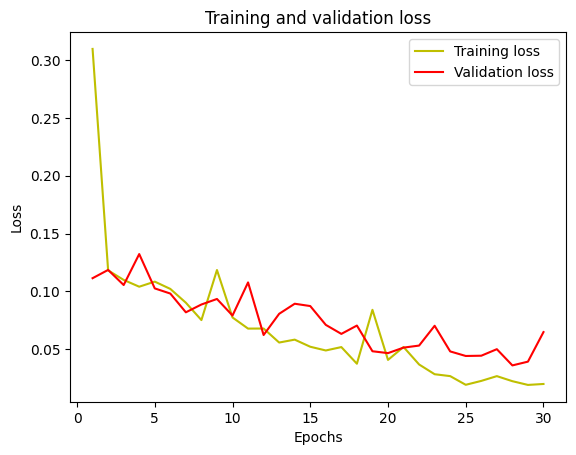

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

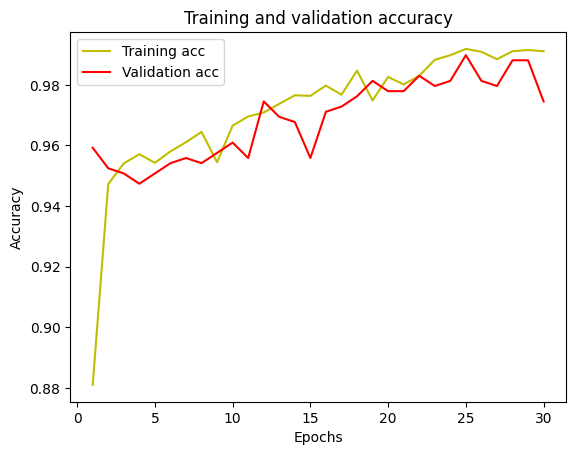

In [6]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
[[470   3  22   1   0   0]
 [  2 462   7   0   0   0]
 [  0  10 410   0   0   0]
 [  0   8   0 427  55   1]
 [  1   3   0  53 475   0]
 [  0  23   0   0   0 514]]
0.9358669833729216
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.91      0.98      0.94       471
           2       0.93      0.98      0.95       420
           3       0.89      0.87      0.88       491
           4       0.90      0.89      0.89       532
           5       1.00      0.96      0.98       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

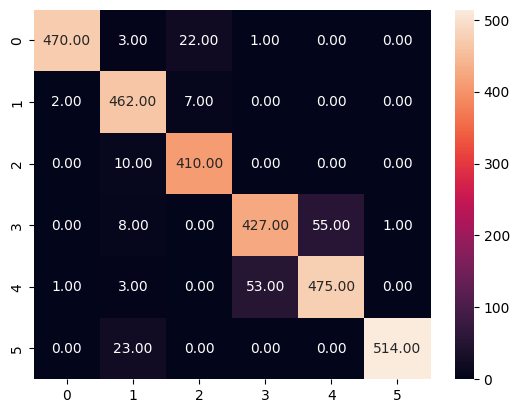

In [7]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn3_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

#LSTM

In [12]:
#데이터 분류는 이미 되어 다시 할 필요 없음
#LSTM을 사용하는 모델 구성

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train_one_hot.shape[1]

inputs = Input(shape=(n_timesteps, n_features))

#LSTM 첫번째 계층 (relu 사용시 값이 이상해서 tanh으로 설정)
lstm_layer_1 = LSTM(units=100, return_sequences=True, activation='tanh')(inputs)

#LSTM 두번째 계층 (relu 사용시 값이 이상해서 tanh으로 설정)
lstm_layer_2 = LSTM(units=100, activation='tanh')(lstm_layer_1)

outputs = Dense(n_outputs, activation='softmax')(lstm_layer_2)

#LSTM 모델
lstm_model = Model(inputs=inputs, outputs=outputs)

In [13]:
#모델 요약
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128, 100)       │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,006 (488.30 KB)

 Trainable params: 125,006 (488.30 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#모델 훈련
model_history = lstm_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4774 - loss: 1.2096 - val_accuracy: 0.7504 - val_loss: 0.6042
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7954 - loss: 0.5366 - val_accuracy: 0.8761 - val_loss: 0.3124
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9008 - loss: 0.2785 - val_accuracy: 0.9355 - val_loss: 0.1499
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9407 - loss: 0.1675 - val_accuracy: 0.9491 - val_loss: 0.1577
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9468 - loss: 0.1579 - val_accuracy: 0.7674 - val_loss: 0.7098
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9064 - loss: 0.2841 - val_accuracy: 0.9100 - val_loss: 0.2137
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9369 - loss: 0.1729 - val_accuracy: 0.9372 - val_loss: 0.1562
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9334 - loss: 0.1595 - val_accu

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[484   4   1   7   0   0]
 [211 243   1   2  14   0]
 [ 31  33 356   0   0   0]
 [  2  25   0 417  47   0]
 [  0   2   0 110 420   0]
 [  0  27   0   0   0 510]]
0.8245673566338649
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       496
           1       0.73      0.52      0.60       471
           2       0.99      0.85      0.92       420
           3       0.78      0.85      0.81       491
           4       0.87      0.79      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.82      2947
   macro avg       0.84      0.82      0.82      2947
weighted avg       0.84      0.82      0.82      2947



<Axes: >

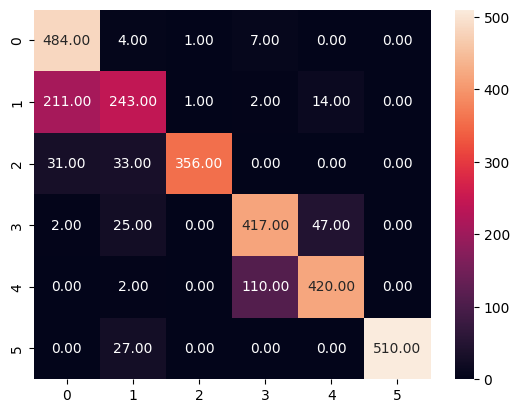

In [15]:
#모델 평가
pred = lstm_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

CNN+LSTM

In [16]:
#모델 학습

inputs = Input(shape=(n_timesteps, n_features))
cnn_layer = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(inputs)
pool_layer = MaxPooling1D(pool_size=4)(cnn_layer) #시퀀스 길이를 1/4로 만듦
lstm_layer = LSTM(units=100, activation='relu')(pool_layer)
outputs = Dense(n_outputs, activation='softmax')(lstm_layer)

In [17]:
#모델 생성
cnn_lstm_model = Model(inputs=inputs, outputs=outputs)

In [18]:
#모델 확인
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_lstm_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,094 (383.18 KB)

 Trainable params: 98,094 (383.18 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#모델 훈련
model_history_cnn_lstm = cnn_lstm_model.fit(
    x=X_train, # 단일 입력 사용
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5818 - loss: 1.0941 - val_accuracy: 0.8557 - val_loss: 0.3537
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8945 - loss: 0.2686 - val_accuracy: 0.9338 - val_loss: 0.1381
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9332 - loss: 0.1660 - val_accuracy: 0.9525 - val_loss: 0.1605
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9458 - loss: 0.1424 - val_accuracy: 0.9253 - val_loss: 0.1490
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9341 - loss: 0.1600 - val_accuracy: 0.9457 - val_loss: 0.3462
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9191 - loss: 0.2619 - val_accuracy: 0.9440 - val_loss: 0.1525
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9528 - loss: 0.1236 - val_accuracy: 0.9457 - val_loss: 0.1129
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9525 - loss: 0.1162 - val_accuracy: 0

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[486   5   5   0   0   0]
 [  7 442  22   0   0   0]
 [  3   5 412   0   0   0]
 [  0   7   0 385  99   0]
 [  1   0   0  79 452   0]
 [  0  27   0   0   0 510]]
0.9117746861214795
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       496
           1       0.91      0.94      0.92       471
           2       0.94      0.98      0.96       420
           3       0.83      0.78      0.81       491
           4       0.82      0.85      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

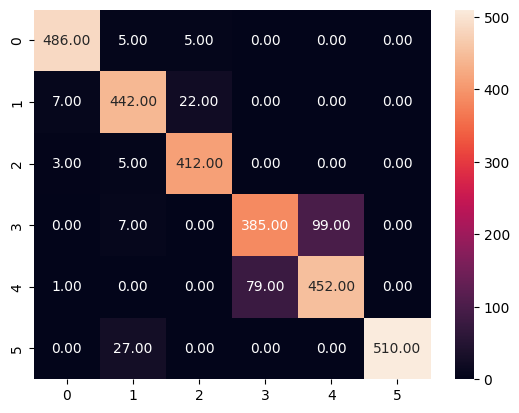

In [20]:
#모델 평가
pred = cnn_lstm_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

Resnet 사용해보기 (gemini 도움)

resnet이란 지름길연결을 사용해서 입력값을 출력값에 직접 더해주는 것

In [26]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add, Input, Dense, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# resnet의 핵심인 Residual Block을 정의
def residual_block(input_tensor, filters, kernel_size, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'

    shortcut = input_tensor

    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=-1, name=conv_name_base + '2a_bn')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=-1, name=conv_name_base + '2b_bn')(x)

    # 현재 숏컷의 필터(채널) 수와 블록의 목표 필터 수가 다를 경우:
    if K.int_shape(shortcut)[-1] != filters:
        # 1x1 Conv1D를 적용하여 필터 수를 맞춥니다.
        shortcut = Conv1D(filters, kernel_size=1, strides=1, padding='same',
                          kernel_initializer='he_normal', name=conv_name_base + '1')(shortcut)

    add_name = 'stage' + str(stage) + '_' + block + '_add'
    x = Add(name=add_name)([x, shortcut])

    relu_name = 'stage' + str(stage) + '_' + block + '_out'
    x = Activation('relu', name=relu_name)(x)

    return x

In [27]:
# (n_timesteps, n_features, n_outputs 변수는 이미 정의되어 있다고 가정)
n_timesteps = 128
n_features = 9
n_outputs = 6

inputs = Input(shape=(n_timesteps, n_features), name='Input_Time_Series')

# 1. 초기 Conv (Output filters: 64)
x = Conv1D(filters=64, kernel_size=7, padding='same',
           kernel_initializer='he_normal', name='Initial_Conv')(inputs)
x = BatchNormalization(axis=-1, name='Initial_BN')(x)
x = Activation('relu', name='Initial_ReLU')(x)

# 2. 잔차 블록(Residual Blocks) 쌓기

# Stage 1: filters=64 (Identity Shortcut: 64 -> 64)
x = residual_block(x, filters=64, kernel_size=5, stage=1, block='a')
x = residual_block(x, filters=64, kernel_size=5, stage=1, block='b')

# Stage 2: filters=128 (Projection Shortcut 적용: 64 -> 128)
x = residual_block(x, filters=128, kernel_size=5, stage=2, block='a')
x = residual_block(x, filters=128, kernel_size=5, stage=2, block='b')

# 3. Global Pooling 및 출력 계층
x = GlobalAveragePooling1D(name='Global_Pool')(x)

# 4. Dense 출력 계층
outputs = Dense(n_outputs, activation='softmax', name='Dense_Output')(x)

# 5. 모델 생성 및 컴파일
resnet_model = Model(inputs=inputs, outputs=outputs, name='ResNet_1D_Model')

In [30]:
#모델 요약
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_model.summary()

Model: "ResNet_1D_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Time_Series   │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Initial_Conv        │ (None, 128, 64)   │      4,096 │ Input_Time_Serie… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Initial_BN          │ (None, 128, 64)   │        256 │ Initial_Conv[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Initial_ReLU        │ (None, 128, 64)   │          0 │ Initial_BN[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2a      │ (None, 128, 64)   │     20,544 │ Initial_ReLU[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2a_bn   │ (None, 128, 64)   │        256 │ res1a_branch2a[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2a_relu │ (None, 128, 64)   │          0 │ res1a_branch2a_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2b      │ (None, 128, 64)   │     20,544 │ res1a_branch2a_r… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2b_bn   │ (None, 128, 64)   │        256 │ res1a_branch2b[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_a_add (Add)  │ (None, 128, 64)   │          0 │ res1a_branch2b_b… │
│                     │                   │            │ Initial_ReLU[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_a_out        │ (None, 128, 64)   │          0 │ stage1_a_add[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2a      │ (None, 128, 64)   │     20,544 │ stage1_a_out[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2a_bn   │ (None, 128, 64)   │        256 │ res1b_branch2a[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2a_relu │ (None, 128, 64)   │          0 │ res1b_branch2a_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2b      │ (None, 128, 64)   │     20,544 │ res1b_branch2a_r… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2b_bn   │ (None, 128, 64)   │        256 │ res1b_branch2b[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_b_add (Add)  │ (None, 128, 64)   │          0 │ res1b_branch2b_b

 Total params: 385,926 (1.47 MB)

 Trainable params: 384,262 (1.47 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [31]:
#모델 학습
model_history_resnet = resnet_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.8228 - loss: 0.4647 - val_accuracy: 0.8065 - val_loss: 0.4393
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9372 - loss: 0.1615 - val_accuracy: 0.9508 - val_loss: 0.1155
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9494 - loss: 0.1299 - val_accuracy: 0.9576 - val_loss: 0.0966
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9489 - loss: 0.1241 - val_accuracy: 0.9117 - val_loss: 0.2263
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9525 - loss: 0.1156 - val_accuracy: 0.9525 - val_loss: 0.1108
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9537 - loss: 0.1193 - val_accuracy: 0.9525 - val_loss: 0.1039
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9499 - loss: 0.1248 - val_accuracy: 0.9440 - val_loss: 0.1038
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9543 - loss: 0.1096 - val_accuracy: 

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[494   0   0   0   2   0]
 [ 42 413   9   6   1   0]
 [ 19   0 401   0   0   0]
 [  0   1   0 378 111   1]
 [  1   0   0  34 497   0]
 [  0   0   0   0   0 537]]
0.9229725144214456
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       496
           1       1.00      0.88      0.93       471
           2       0.98      0.95      0.97       420
           3       0.90      0.77      0.83       491
           4       0.81      0.93      0.87       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



<Axes: >

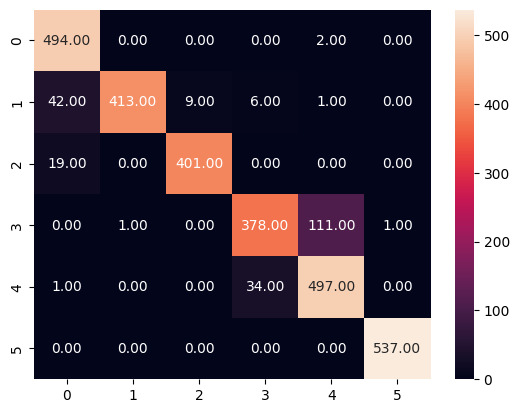

In [33]:
#모델 평가
pred = resnet_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

Transformer Encoder(gemini 사용)

In [34]:
from tensorflow.keras.layers import Layer, MultiHeadAttention, Dropout, LayerNormalization, Dense, Add, Input, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model
import tensorflow as tf

# 입력 데이터의 형태를 정의합니다: (타임스텝, 특징 수)
n_timesteps = 128
n_features = 9
n_outputs = 6
embedding_dim = 64 # 임베딩 차원 (Transformer 모델의 깊이)
num_heads = 4      # Multi-Head Attention의 헤드 수
ff_dim = 128       # Feed Forward Network의 은닉 차원

#모델 정의
# --- Position Embedding 계층 ---
class PositionEmbedding(Layer):
    def __init__(self, max_length, embedding_dim, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=max_length, output_dim=embedding_dim)

    def call(self, x):
        # 입력 텐서의 길이 (Timesteps)를 가져옵니다.
        maxlen = tf.shape(x)[1]
        # 0부터 maxlen-1까지의 정수 시퀀스를 만듭니다.
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # 위치 임베딩을 계산합니다.
        position_embedding = self.pos_emb(positions)
        # 입력 시퀀스와 위치 임베딩을 더합니다.
        return x + position_embedding

# --- Transformer Encoder Block 함수 ---
def transformer_encoder_block(inputs):
    # 1. Multi-Head Attention (Self-Attention)
    # 입력을 Query, Key, Value로 사용
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1)(inputs, inputs)

    # 2. Add & Normalize (잔차 연결 및 Layer Normalization)
    x = Add()([inputs, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    # 3. Feed Forward Network
    ffn_output = Dense(ff_dim, activation="relu")(x)
    ffn_output = Dropout(0.1)(ffn_output)
    ffn_output = Dense(embedding_dim)(ffn_output)

    # 4. Add & Normalize (잔차 연결 및 Layer Normalization)
    x = Add()([x, ffn_output])
    return LayerNormalization(epsilon=1e-6)(x)

In [35]:
inputs = Input(shape=(n_timesteps, n_features), name='Input_Time_Series')

x = Dense(embedding_dim, name='Initial_Projection')(inputs)

x = PositionEmbedding(max_length=n_timesteps, embedding_dim=embedding_dim, name='Position_Embedding')(x)

x = transformer_encoder_block(x)
x = transformer_encoder_block(x)

x = GlobalAveragePooling1D(name='Global_Pool')(x)

outputs = Dense(n_outputs, activation='softmax', name='Dense_Output')(x)

In [37]:
#모델 요약
transformer_model = Model(inputs=inputs, outputs=outputs, name='Transformer_Encoder_Model')

transformer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
transformer_model.summary()

Model: "Transformer_Encoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Time_Series   │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Initial_Projection  │ (None, 128, 64)   │        640 │ Input_Time_Serie… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Position_Embedding  │ (None, 128, 64)   │      8,192 │ Initial_Projecti… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 64)   │     16,640 │ Position_Embeddi… │
│ (MultiHeadAttentio… │                   │            │ Position_Embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ Position_Embeddi… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128)  │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128, 64)   │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 64)   │        128 │ add_3[0][0]     

 Total params: 76,166 (297.52 KB)

 Trainable params: 76,166 (297.52 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
#모델 학습
model_history_transformer = transformer_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - accuracy: 0.7119 - loss: 0.7631 - val_accuracy: 0.9287 - val_loss: 0.1488
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9417 - loss: 0.1597 - val_accuracy: 0.9389 - val_loss: 0.1192
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9477 - loss: 0.1180 - val_accuracy: 0.9389 - val_loss: 0.1445
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9494 - loss: 0.1297 - val_accuracy: 0.9440 - val_loss: 0.1214
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9471 - loss: 0.1202 - val_accuracy: 0.9474 - val_loss: 0.1024
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9579 - loss: 0.1027 - val_accuracy: 0.9525 - val_loss: 0.1003
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9577 - loss: 0.0966 - val_accuracy: 0.9542 - val_loss: 0.1003
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9574 - loss: 0.1024 - val_accura

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
[[460  22  14   0   0   0]
 [  8 439  24   0   0   0]
 [  8   2 410   0   0   0]
 [  0   2   0 386  82  21]
 [  0   0   0  77 455   0]
 [  0   0   0   0   0 537]]
0.9117746861214795
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       496
           1       0.94      0.93      0.94       471
           2       0.92      0.98      0.94       420
           3       0.83      0.79      0.81       491
           4       0.85      0.86      0.85       532
           5       0.96      1.00      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

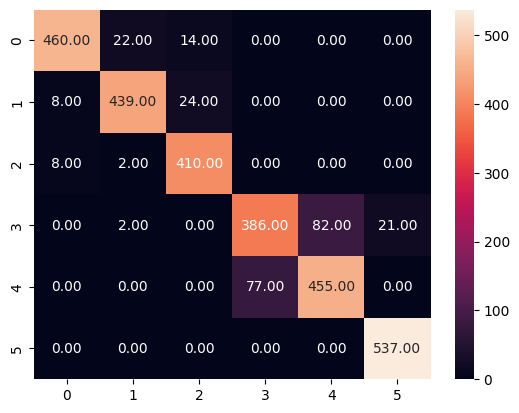

In [39]:
#모델 평가
pred = transformer_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

Transformer+Resnet

In [40]:
#변수 설정
n_timesteps = 128
n_features = 9
n_outputs = 6
embedding_dim = 64 # Transformer 입력 및 내부 차원
num_heads = 4      # Multi-Head Attention의 헤드 수
ff_dim = 128

In [41]:
def residual_block(input_tensor, filters, kernel_size, stage, block):
    shortcut = input_tensor
    conv_name_base = 'res' + str(stage) + block + '_branch'

    # Conv1D 1
    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=-1, name=conv_name_base + '2a_bn')(x)
    x = Activation('relu', name=conv_name_base + '2a_relu')(x)

    # Conv1D 2
    x = Conv1D(filters, kernel_size=kernel_size, padding='same',
               kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=-1, name=conv_name_base + '2b_bn')(x)

    # 숏컷 경로 (Projection Shortcut 조건부 추가)
    if K.int_shape(shortcut)[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=1, padding='same',
                          kernel_initializer='he_normal', name=conv_name_base + '1')(shortcut)

    # 최종 결합
    add_name = 'stage' + str(stage) + '_' + block + '_add'
    x = Add(name=add_name)([x, shortcut])
    relu_name = 'stage' + str(stage) + '_' + block + '_out'
    x = Activation('relu', name=relu_name)(x)

    return x

# --- 2. Transformer Helper Layer/Function ---

# Position Embedding 계층
class PositionEmbedding(Layer):
    def __init__(self, max_length, embedding_dim, **kwargs):
        super(PositionEmbedding, self).__init__(**kwargs)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=max_length, output_dim=embedding_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embedding = self.pos_emb(positions)
        return x + position_embedding

# Transformer Encoder Block 함수
def transformer_encoder_block(inputs, layer_name):
    # 1. Multi-Head Attention (Self-Attention)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim // num_heads, dropout=0.1, name=layer_name+'_MHA')(inputs, inputs)

    # 2. Add & Normalize (잔차 연결 및 Layer Normalization)
    x = Add(name=layer_name+'_Add1')([inputs, attn_output])
    x = LayerNormalization(epsilon=1e-6, name=layer_name+'_Norm1')(x)

    # 3. Feed Forward Network
    ffn_output = Dense(ff_dim, activation="relu", name=layer_name+'_FFN1')(x)
    ffn_output = Dropout(0.1)(ffn_output)
    ffn_output = Dense(embedding_dim, name=layer_name+'_FFN2')(ffn_output)

    # 4. Add & Normalize (잔차 연결 및 Layer Normalization)
    x = Add(name=layer_name+'_Add2')([x, ffn_output])
    return LayerNormalization(epsilon=1e-6, name=layer_name+'_Norm2')(x)

In [42]:
#모델 정의
inputs = Input(shape=(n_timesteps, n_features), name='Input_Time_Series')

#resnet 부분

x = Conv1D(filters=64, kernel_size=7, padding='same',
           kernel_initializer='he_normal', name='Initial_Conv')(inputs)
x = BatchNormalization(axis=-1, name='Initial_BN')(x)
x = Activation('relu', name='Initial_ReLU')(x)

x = residual_block(x, filters=64, kernel_size=5, stage=1, block='a')
x = residual_block(x, filters=64, kernel_size=5, stage=1, block='b')

x = residual_block(x, filters=128, kernel_size=5, stage=2, block='a')
x = residual_block(x, filters=128, kernel_size=5, stage=2, block='b')

x = Conv1D(embedding_dim, kernel_size=1, padding='same', name='ResNet_to_Transformer_Projection')(x)
x = Activation('relu', name='Projection_ReLU')(x)


#transformer encoderㅈ 부분

x = PositionEmbedding(max_length=n_timesteps, embedding_dim=embedding_dim, name='Position_Embedding')(x)

x = transformer_encoder_block(x, layer_name='Transformer_1')
x = transformer_encoder_block(x, layer_name='Transformer_2')

x = GlobalAveragePooling1D(name='Global_Pool')(x)

outputs = Dense(n_outputs, activation='softmax', name='Dense_Output')(x)

#전체 모델 완성
resnet_transformer_model = Model(inputs=inputs, outputs=outputs, name='ResNet_Transformer_Model')

In [43]:
#모델 요약
resnet_transformer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_transformer_model.summary()

Model: "ResNet_Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Time_Series   │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Initial_Conv        │ (None, 128, 64)   │      4,096 │ Input_Time_Serie… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Initial_BN          │ (None, 128, 64)   │        256 │ Initial_Conv[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Initial_ReLU        │ (None, 128, 64)   │          0 │ Initial_BN[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2a      │ (None, 128, 64)   │     20,544 │ Initial_ReLU[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2a_bn   │ (None, 128, 64)   │        256 │ res1a_branch2a[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2a_relu │ (None, 128, 64)   │          0 │ res1a_branch2a_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2b      │ (None, 128, 64)   │     20,544 │ res1a_branch2a_r… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1a_branch2b_bn   │ (None, 128, 64)   │        256 │ res1a_branch2b[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_a_add (Add)  │ (None, 128, 64)   │          0 │ res1a_branch2b_b… │
│                     │                   │            │ Initial_ReLU[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_a_out        │ (None, 128, 64)   │          0 │ stage1_a_add[0][… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2a      │ (None, 128, 64)   │     20,544 │ stage1_a_out[0][… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2a_bn   │ (None, 128, 64)   │        256 │ res1b_branch2a[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2a_relu │ (None, 128, 64)   │          0 │ res1b_branch2a_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2b      │ (None, 128, 64)   │     20,544 │ res1b_branch2a_r… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res1b_branch2b_bn   │ (None, 128, 64)   │        256 │ res1b_branch2b[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_b_add (Add)  │ (None, 128, 64)   │          0 │ res1b_branch2b_b

 Total params: 468,934 (1.79 MB)

 Trainable params: 467,270 (1.78 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [44]:
#모델 훈련
model_history_hybrid = resnet_transformer_model.fit(
     x=X_train,
     y=y_train_one_hot,
     epochs=30,
     batch_size=32,
     validation_split=0.1
 )

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 48s 119ms/step - accuracy: 0.7692 - loss: 0.5710 - val_accuracy: 0.7708 - val_loss: 0.4589
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9396 - loss: 0.1571 - val_accuracy: 0.9372 - val_loss: 0.1647
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9447 - loss: 0.1467 - val_accuracy: 0.9610 - val_loss: 0.1013
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9393 - loss: 0.1431 - val_accuracy: 0.9423 - val_loss: 0.1327
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9305 - loss: 0.1582 - val_accuracy: 0.9355 - val_loss: 0.1427
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9502 - loss: 0.1234 - val_accuracy: 0.9474 - val_loss: 0.1043
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9568 - loss: 0.1080 - val_accuracy: 0.9491 - val_loss: 0.1146
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9544 - loss: 0.1220 - val_ac

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
[[470   6  17   3   0   0]
 [  3 446  16   5   1   0]
 [  0   0 420   0   0   0]
 [  0   1   0 416  72   2]
 [  0   0   0  83 449   0]
 [  0   0   0   0   0 537]]
0.9290804207668816
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.98      0.95      0.97       471
           2       0.93      1.00      0.96       420
           3       0.82      0.85      0.83       491
           4       0.86      0.84      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

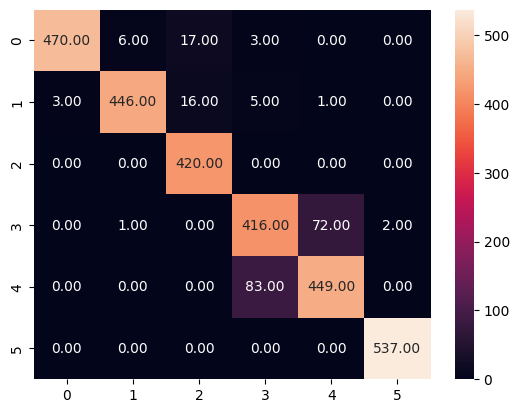

In [45]:
#모델 평가
pred = resnet_transformer_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt = '.2f')